# symmetry

In [8]:
import sys

import cv2
import matplotlib.pyplot as plt
import numpy as np


# sift = cv2.xfeatures2d.SIFT_create()
# sift = cv2.xfeatures2d.SIFT_create()


def very_close(a, b, tol=5.0):
    """Checks if the points a, b are within
    tol distance of each other."""
    return np.sqrt((a[0] - b[0]) ** 2 + (a[1] - b[1]) ** 2) < tol


def S(si, sj, sigma=1):
    """Computes the 'S' function mentioned in
    the research paper."""
    q = (-abs(si - sj)) / (sigma * (si + sj))
    return np.exp(q ** 2)


def reisfeld(phi, phj, theta):
    return 1 - np.cos(phi + phj - 2 * theta)


def midpoint(i, j):
    return (i[0] + j[0]) / 2, (i[1] + j[1]) / 2


def angle_with_x_axis(i, j):
    x, y = i[0] - j[0], i[1] - j[1]
    if x == 0:
        return np.pi / 2
    angle = np.arctan(y / x)
    if angle < 0:
        angle += np.pi
    return angle


def superm2(image):
    """Performs the symmetry detection on image.
    Somewhat clunky at the moment -- first you 
    must comment out the last two lines: the 
    call to `draw` and `cv2.imshow` and uncomment
    `hex` call. This will show a 3d histogram, where
    bright orange/red is the maximum (most voted for
    line of symmetry). Manually get the coordinates,
    and re-run but this time uncomment draw/imshow."""
    sift = cv2.SIFT_create()
    mimage = np.fliplr(image)
    kp1, des1 = sift.detectAndCompute(image, None)
    kp2, des2 = sift.detectAndCompute(mimage, None)
    # for p, mp in zip(kp1, kp2):
    #     p.angle = np.deg2rad(p.angle)
    #     mp.angle = np.deg2rad(mp.angle)
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)
    good = []
    for m, n in matches:
        point = kp1[m.queryIdx]
        mirpoint = kp2[m.trainIdx]
        if m.distance < 0.75 * n.distance and very_close(point.pt, mirpoint.pt) == False:
            good.append(m)
        # point = kp1[match.queryIdx]
        # mirpoint = kp2[match.trainIdx]
        # mirpoint2 = kp2[match2.trainIdx]
        # mirpoint2.angle = np.pi - mirpoint2.angle
        # mirpoint.angle = np.pi - mirpoint.angle
        # if mirpoint.angle < 0.0:
        #     mirpoint.angle += 2 * np.pi
        # if mirpoint2.angle < 0.0:
        #     mirpoint2.angle += 2 * np.pi
        # mirpoint.pt = (mimage.shape[1] - mirpoint.pt[0], mirpoint.pt[1])
        # if very_close(point.pt, mirpoint.pt):
        #     mirpoint = mirpoint2
        #     good.append(match2)
        # else:
        #     good.append(match)
        # theta = angle_with_x_axis(point.pt, mirpoint.pt)
        # xc, yc = midpoint(point.pt, mirpoint.pt)
        # r = xc * np.cos(theta) + yc * np.sin(theta)
        # Mij = reisfeld(point.angle, mirpoint.angle, theta) * S(
        #     point.size, mirpoint.size
        # )
    # matches = sorted(matches, key = lambda x:x.distance)
    good = sorted(good, key=lambda x: x.distance)

    return kp1, kp2, good

    # def draw(r, theta):
    #     if np.pi / 4 < theta < 3 * (np.pi / 4):
    #         for x in range(len(image.T)):
    #             y = int((r - x * np.cos(theta)) / np.sin(theta))
    #             if 0 <= y < len(image.T[x]):
    #                 image[y][x] = 255
    #     else:
    #         for y in range(len(image)):
    #             x = int((r - y * np.sin(theta)) / np.cos(theta))
    #             if 0 <= x < len(image[y]):
    #                 image[y][x] = 255

    # img3 = cv2.drawMatches(image, kp1, mimage, kp2, good[:15], None, flags=2)
    # # print(*(m.distance for m in matches[:10]))
    # # cv2.imshow('a',img3); cv2.waitKey(0);
    # def hex():
    #     plt.hexbin(houghr, houghth, bins=200)
    #     plt.show()

    # hex()
    # draw(2.8, 2.4)
    # cv2.imshow('a', image)


def draw(image, r, theta):
    if np.pi / 4 < theta < 3 * (np.pi / 4):
        for x in range(len(image.T)):
            y = int((r - x * np.cos(theta)) / np.sin(theta))
            if 0 <= y < len(image.T[x]):
                image[y][x] = 255
    else:
        for y in range(len(image)):
            x = int((r - y * np.sin(theta)) / np.cos(theta))
            if 0 <= x < len(image[y]):
                image[y][x] = 255

# priors

In [9]:
bone_range = [2000, 4500]

flesh_range = [300, 1000]

# load dicom imgs

In [10]:
import cv2 as cv
import os
import numpy as np
import matplotlib.pyplot as plt

import pydicom
from pydicom import dcmread

import statsmodels.api as sm

In [11]:
dcm_dir =  r"H:\hhx\hhx_works\scientific_visualization_2021\visualization-data\dicom_data"
dcm_files = [d for d in os.listdir(dcm_dir) if d.endswith('.dcm')]
for i in range(len(dcm_files)):
  dcm_files[i] = os.path.join(dcm_dir, dcm_files[i])

In [12]:
def get_img(file_path):
  img = (dcmread(file_path).pixel_array / 5000 * 256).astype(np.uint8)
  return img

In [21]:
def get_sagittal_line(img):
  kp1, kp2, goods = superm2(img)
  pointsI = []
  pointsJ = []
  for g in goods:
    # print(g.distance, g.imgIdx, g.queryIdx, g.trainIdx)
    point1 = kp1[g.queryIdx]
    point2 = kp2[g.trainIdx]
    pointsJ.append((point1.pt[0] + point2.pt[0])/2)
    pointsI.append((point1.pt[1] + point2.pt[1])/2)

  pointsI_const = sm.add_constant(pointsI)
  rlm_model = sm.RLM(pointsJ, pointsI_const)
  rlm_results = rlm_model.fit()

  # predict
  a = [0, 500]
  a_const = sm.add_constant(a)
  b = rlm_results.predict(a_const)

  return a, b, pointsI, pointsJ

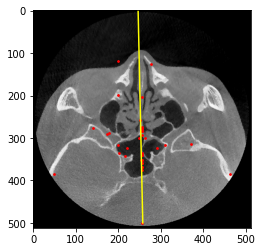

In [41]:
img = get_img(dcm_files[330])

a, b, k, l = get_sagittal_line(img)
plt.scatter(l, k, c='red', s=3)
plt.plot(b, a, c='yellow')
plt.imshow(img, cmap='Greys_r')

In [42]:
for i in range(500):
  img = get_img(dcm_files[i])

  a, b, k, l = get_sagittal_line(img)